In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report, accuracy_score, recall_score

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

from imblearn.pipeline import Pipeline
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [72]:
df = pd.read_csv("BankChurners.csv")
df = df.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2','CLIENTNUM'],axis='columns')
df["Attrition_Flag"] = df["Attrition_Flag"].map({"Existing Customer":0, "Attrited Customer":1})
le = LabelEncoder()
df['Education_Level']= le.fit_transform(df['Education_Level'])
df['Gender']= le.fit_transform(df['Gender'])
df['Card_Category']= le.fit_transform(df['Card_Category'])
df['Income_Category']= le.fit_transform(df['Income_Category'])
df['Marital_Status']= le.fit_transform(df['Marital_Status'])
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,1,3,3,1,2,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,0,5,2,2,4,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,1,3,2,1,3,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,0,4,3,3,4,0,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,1,3,5,1,2,0,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [73]:
k=df.groupby('Attrition_Flag').mean()
print(df[['Attrition_Flag','Gender']].groupby('Attrition_Flag').count())
k

                Gender
Attrition_Flag        
0                 8500
1                 1627


,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
Attrition_Flag,,,,,,,,,,,,,,,,,,,
0,46.262118,0.479059,2.335412,3.092118,1.457412,2.852353,0.181647,35.880588,3.914588,2.273765,2.356353,8726.877518,1256.604118,7470.273400,0.772510,4654.655882,68.672588,0.742434,0.296412
1,46.659496,0.428396,2.402581,3.119852,1.494776,2.924401,0.170252,36.178242,3.279656,2.693301,2.972342,8136.039459,672.822987,7463.216472,0.694277,3095.025814,44.933620,0.554386,0.162475


# Splitting data

In [74]:
X = df.drop(columns=["Attrition_Flag"])
y = df["Attrition_Flag"]
X_train, X_test, y_train, y_test = tts(X, y, stratify=y, test_size=0.2, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Visualization of existing top features with churn

In [ ]:
from itertools import combinations

top_features = [
    'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
    'Avg_Utilization_Ratio', 'Credit_Limit'
]

all_pairs = list(combinations(top_features, 2))

import math

def plot_all_2d_scatter_pairs(df, pairs, target='Attrition_Flag', cols=3):
    rows = math.ceil(len(pairs) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for idx, (f1, f2) in enumerate(pairs):
        sns.scatterplot(
            data=df, x=f1, y=f2, hue=target,
            palette='Set1', alpha=0.6, ax=axes[idx]
        )
        axes[idx].set_title(f'{f1} vs {f2}', fontsize=10)
        axes[idx].legend([], [], frameon=False)

    for j in range(len(pairs), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


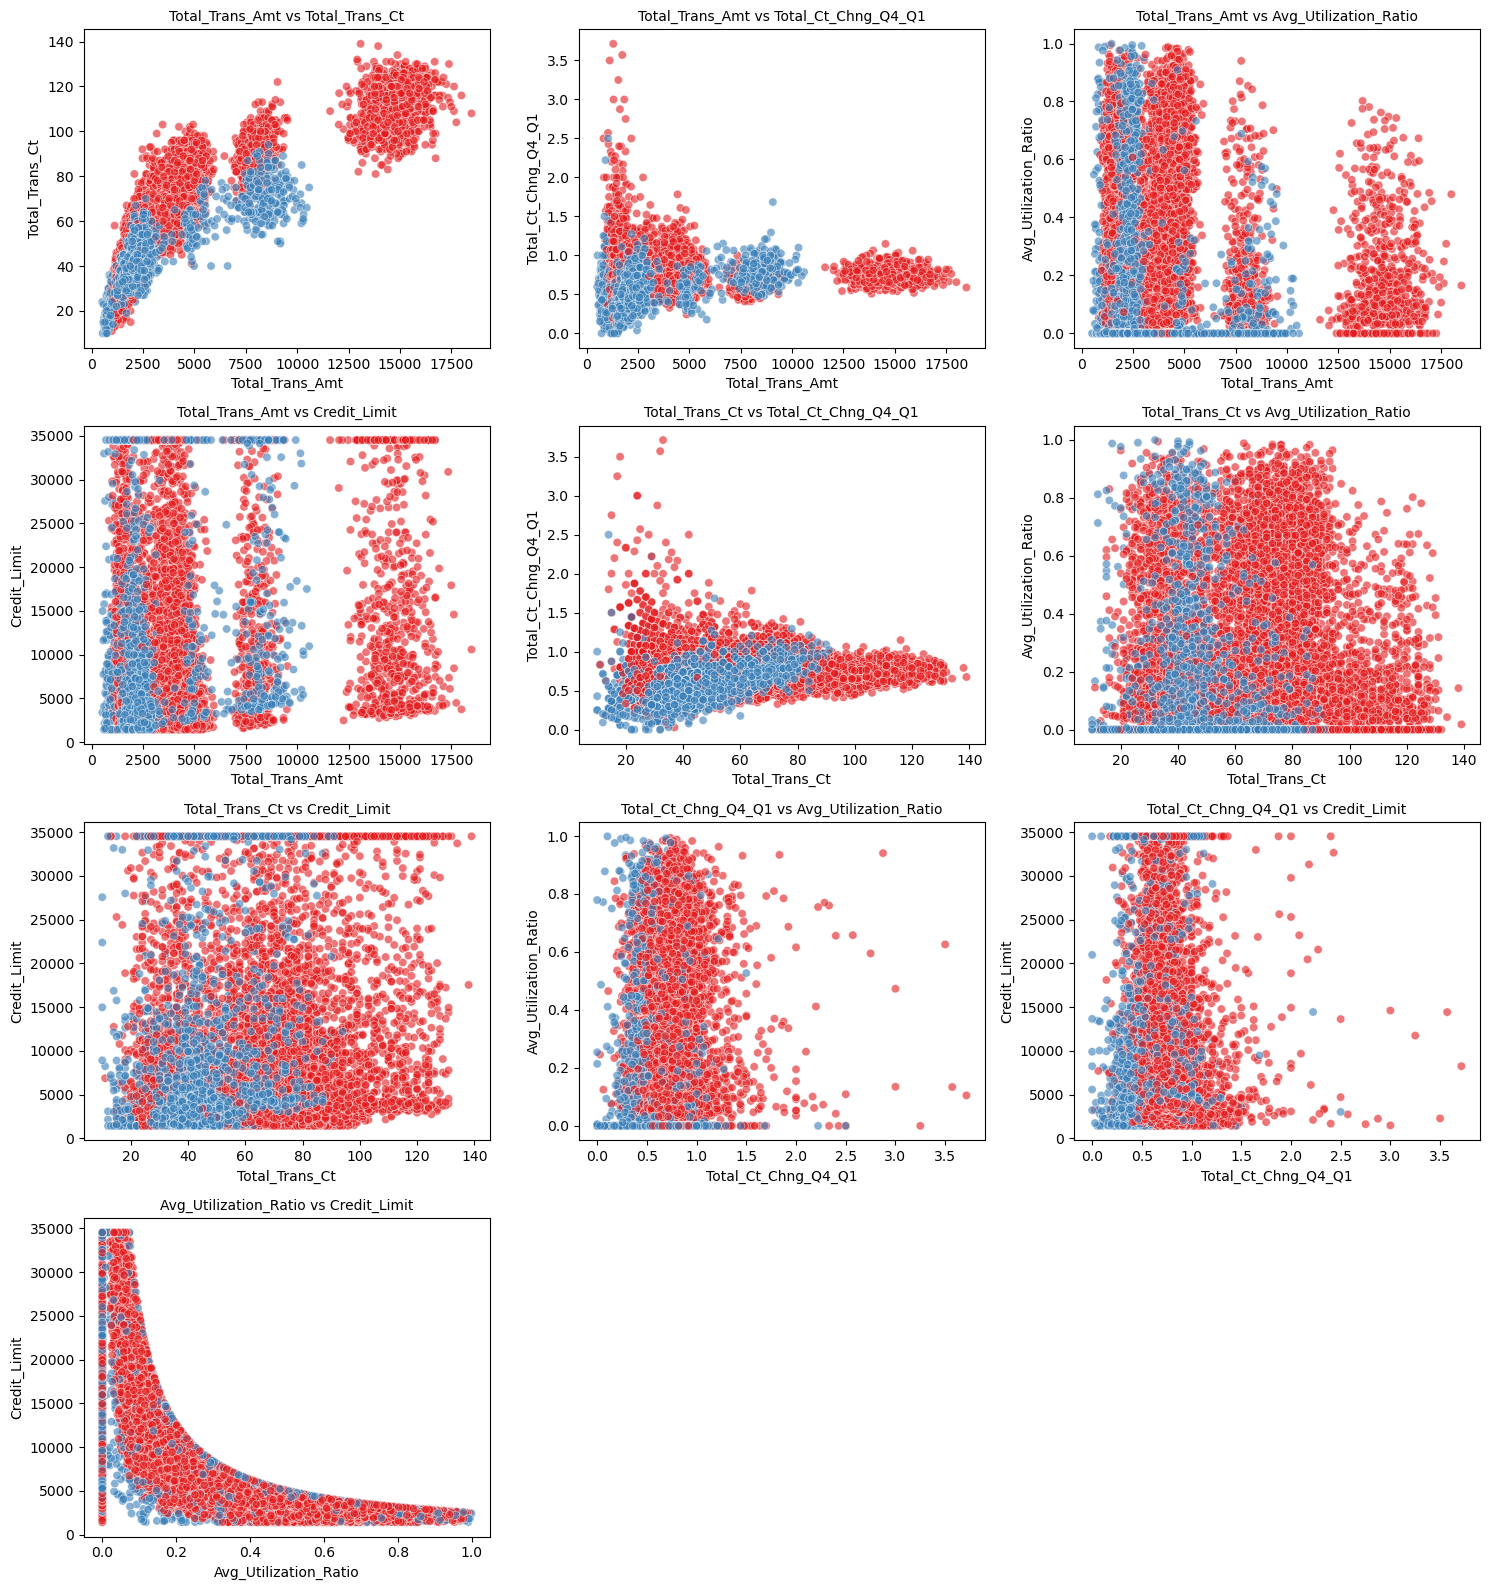

In [27]:
plot_all_2d_scatter_pairs(df, all_pairs)


# Helper Functions
- using pipeline instead of directly using X_resampled, y_resampled to ensure SMOTE is applied only inside the CV folds, not on the full dataset.

In [64]:
def evaluate_model(model, model_name, smote=False, X=None, y=None, cv=None):
    if smote:
        pipeline = Pipeline([
            ('smote', SMOTE(random_state=42)),
            ('classifier', model)
        ])
        estimator = pipeline
    else:
        estimator = model

    acc_scores = cross_val_score(estimator, X, y, cv=cv, scoring='accuracy')
    recall_scores = cross_val_score(estimator, X, y, cv=cv, scoring='recall')

    print(f"\n=== {model_name} {'with SMOTE' if smote else ''} ===")
    print("Accuracy:", np.mean(acc_scores))
    print("Recall:", np.mean(recall_scores))

    return np.mean(acc_scores), np.mean(recall_scores)

def metrics_model(model, model_name, smote=False, X=None, y=None):
    if smote:
        smote = SMOTE(random_state=42)
        X,y = smote.fit_resample(X,y)
    model.fit(X,y)
    print(f"\n===== {model_name} =====")
    y_pred = model.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    cm1 = cm(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

def importances_model(model, model_name, smote=False, X=None, y=None):
    if smote:
        smote = SMOTE(random_state=42)
        X,y = smote.fit_resample(X,y)
    model.fit(X,y)
    print(f"\n===== {model_name} =====")
    importances = model.feature_importances_
    features = X_train.columns
    sns.barplot(x=importances, y=features)
    plt.title("Feature Importances")
    plt.show()


# Introducing new features 

In [81]:

# 1. Transaction Power
df['Trans_Power'] = df['Total_Trans_Amt'] * df['Total_Trans_Ct']

# 2. Stability Index (lower = more stable)
df['Stability_Index'] = 1 / (1 + df['Total_Ct_Chng_Q4_Q1'])

# 3. Spending Efficiency (spending per unit of credit)
df['Spending_Efficiency'] = df['Total_Trans_Amt'] / (1 + df['Credit_Limit'])

# 4. Utilization Efficiency (how much unused credit is available)
df['Utilization_Gap'] = df['Credit_Limit'] * (1 - df['Avg_Utilization_Ratio'])

# 5. Transaction per Credit Ratio
df['Trans_Ct_per_Credit'] = df['Total_Trans_Ct'] / (1 + df['Credit_Limit'])

# 6. Transaction per Change Ratio
df['Trans_Amt_per_Change'] = df['Total_Trans_Amt'] / (1 + df['Total_Ct_Chng_Q4_Q1'])

# 7. Interaction Feature: Change * Utilization
df['Change_x_Util'] = df['Total_Ct_Chng_Q4_Q1'] * df['Avg_Utilization_Ratio']

# 8. Flag: Underutilized heavy spender
df['Underutilized_Heavy_Spender'] = (
    (df['Avg_Utilization_Ratio'] < 0.2) & 
    (df['Total_Trans_Amt'] > df['Total_Trans_Amt'].median())
).astype(int)

# 9. Flag: Stable Low Use
df['Stable_Low_Use'] = (
    (df['Total_Ct_Chng_Q4_Q1'] < 1) & 
    (df['Avg_Utilization_Ratio'] < 0.2)
).astype(int)


print("✅ New features added to df.")
X = df.drop(columns=["Attrition_Flag"])
y = df["Attrition_Flag"]
X_train, X_test, y_train, y_test = tts(X, y, stratify=y, test_size=0.2, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


✅ New features added to df.



===== RandomForestClassifier with new features =====


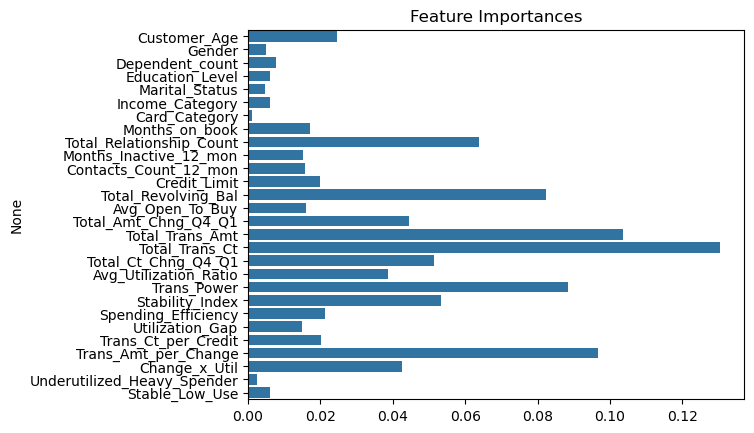

In [82]:
model = RandomForestClassifier(random_state=42)
importances_model(model,"RandomForestClassifier with new features",smote=False,X=X_train,y=y_train)


- Removing least important features to reduce cluttering

Remaining features:
 ['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Trans_Power', 'Stability_Index', 'Spending_Efficiency', 'Utilization_Gap', 'Trans_Ct_per_Credit', 'Trans_Amt_per_Change', 'Change_x_Util', 'Underutilized_Heavy_Spender', 'Stable_Low_Use']

===== RandomForestClassifier with new features =====


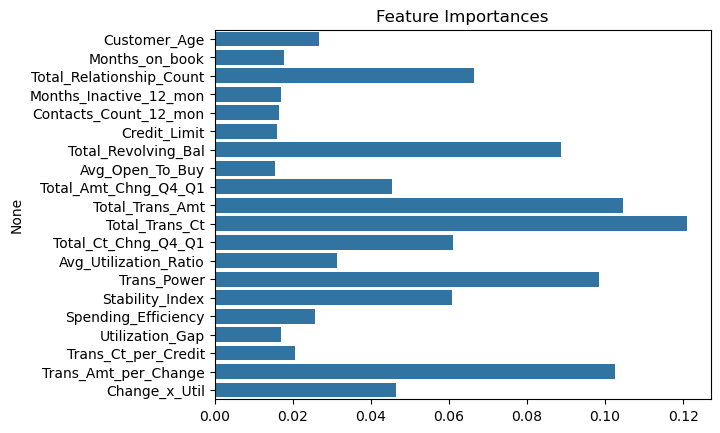

In [ ]:
features_to_drop = [
    'Gender',
    'Education_Level',
    'Dependent_count',
    'Marital_Status',
    'Income_Category',
    'Card_Category',
    'Stable_Low_Use',
    'Underutilized_Heavy_Spender',
]

X_train.drop(columns=features_to_drop, inplace=True)
X_test.drop(columns=features_to_drop, inplace=True)

importances_model(model,"RandomForestClassifier with new features and after removing unnecessary features",smote=False,X=X_train,y=y_train)

In [84]:
rf_accuracy,rf_recall = evaluate_model(model,'Random Forest',smote=False,X=X_train,y=y_train,cv=skf)



=== Random Forest  ===
Accuracy: 0.9648184705371629
Recall: 0.8540819333922782


# What You Realized
- Feature engineering improved model expressiveness and captured behavioral signals.

- The model now depends on a broader range of features, reducing overfitting risk.

- Some engineered features outperformed the original ones, adding real value.

- The training data set very biased.
- And also continuos variables like Customer_Age, Credit_Limit, Total_Revolving_Bal, Avg_Open_To_Buy, Total_Amt_Chng_Q4_Q1, Total_Trans_Amt,	Total_Trans_Ct can be changed into bins for making it better for random forest algorithm

In [30]:
rf = RandomForestClassifier(random_state=42)
rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)


rf_accuracy,rf_recall = evaluate_model(rf,'Random Forest',smote=False,X=X_train,y=y_train,cv=skf)
rf_balanced__accuracy,rf_balanced_recall = evaluate_model(rf_balanced,"Random Forest with class_weight='balanced'",smote=False,X=X_train,y=y_train,cv=skf)
rf_smote_accuracy,rf_smote_recall = evaluate_model(rf,'Random Forest with smote',smote=True,X=X_train,y=y_train,cv=skf)



=== Random Forest  ===
Accuracy: 0.9643243387331399
Recall: 0.8487061597406426

=== Random Forest with class_weight='balanced'  ===
Accuracy: 0.9590167630101828
Recall: 0.8026201002063071

=== Random Forest with smote with SMOTE ===
Accuracy: 0.9608679294140943
Recall: 0.9062923666371943


- So it can be concluded that Random Forest with SMOTE is the best to use.



===== RandomForestClassifier with smote =====


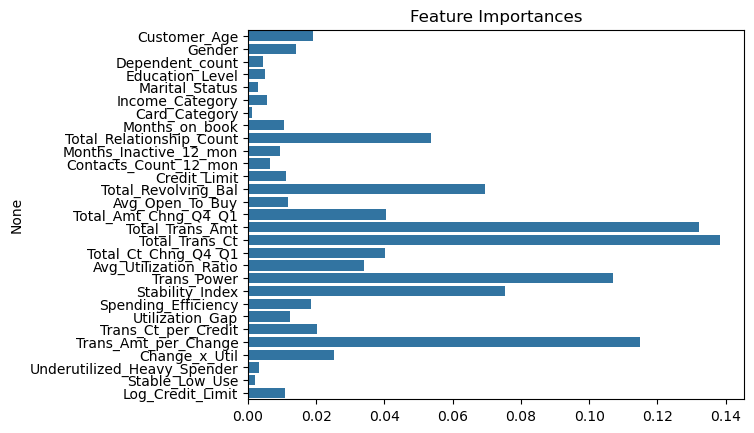

In [ ]:
importances_model(model,"RandomForestClassifier with smote",smote=True,X=X_train,y=y_train)

- Now based on the importances lets try and check if binning a few continous columns improves the importance or not

In [32]:
columns_to_bin = {
    'Total_Trans_Amt': 5,
    'Total_Trans_Ct': 5,
    'Total_Ct_Chng_Q4_Q1': 4,
    'Avg_Utilization_Ratio': 4,
    'Total_Revolving_Bal': 5,
    'Credit_Limit': 4,
    'Customer_Age': 5
}

df_binned = df.copy()

for col, n_bins in columns_to_bin.items():
    bin_col_name = f"{col}_binned"
    df_binned[bin_col_name] = pd.cut(df_binned[col], bins=n_bins, labels=False)
    df_binned.drop(columns=col, inplace=True)

X_binned = df_binned.drop(columns=["Attrition_Flag"])
y_binned = df_binned["Attrition_Flag"]
X_train_binned, X_test_binned, y_train_binned, y_test_binned = tts(X_binned, y_binned, stratify=y_binned, test_size=0.2, random_state=42)
df_binned

,Attrition_Flag,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Underutilized_Heavy_Spender,Stable_Low_Use,Log_Credit_Limit,Total_Trans_Amt_binned,Total_Trans_Ct_binned,Total_Ct_Chng_Q4_Q1_binned,Avg_Utilization_Ratio_binned,Total_Revolving_Bal_binned,Credit_Limit_binned,Customer_Age_binned
0,0,1,3,3,1,2,0,39,5,1,...,0,0,9.448727,0,1,1,0,1,1,2
1,0,0,5,2,2,4,0,44,6,1,...,0,0,9.018817,0,0,3,0,1,0,2
2,0,1,3,2,1,3,0,36,4,1,...,0,0,8.137103,0,0,2,0,0,0,2
3,0,0,4,3,3,4,0,34,3,4,...,0,0,8.105911,0,0,2,3,4,0,1
4,0,1,3,5,1,2,0,21,5,1,...,0,0,8.458928,0,0,2,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0,1,2,2,2,1,0,40,3,2,...,0,0,8.295049,4,4,0,1,3,0,2
10123,1,1,2,6,0,1,0,25,4,2,...,0,0,8.361241,2,2,0,2,4,0,1
10124,1,0,1,3,1,4,0,36,5,3,...,1,1,8.596004,2,1,0,0,0,0,1
10125,1,1,2,2,3,1,0,36,4,3,...,1,1,8.572060,2,2,0,0,0,0,0


In [33]:
rf_binned_accuracy,rf_binned_recall = evaluate_model(rf,'Random Forest using Manual binning',smote=True,X=X_train_binned,y=y_train_binned,cv=skf)


=== Random Forest using Manual binning with SMOTE ===
Accuracy: 0.9550665265306435
Recall: 0.8832714412024757


- Manual binning reduced the performance of Random Forest with smote
- These classifiers—Decision Tree, Random Forest, XGBoost, and CatBoost—automatically determine the most efficient split points for continuous features during training, using techniques like dynamic thresholding or automatic binning. As a result, manual binning is unnecessary, as they are designed to handle raw continuous data effectively.

So we must not do manual binning.

In [34]:
print("\n=== Random Forest with SMOTE ===")
print("Accuracy:", rf_smote_accuracy)
print("Recall:", rf_smote_recall)

xgb_smote = XGBClassifier(eval_metric='logloss', random_state=42)
lgbm_smote = LGBMClassifier(verbose=-1, random_state=42)
catboost_smote = CatBoostClassifier(verbose=0, random_state=42)

xgb_smote_accuracy,xgb_smote_recall = evaluate_model(xgb_smote,'XGboost',smote=True,X=X_train,y=y_train,cv=skf)
lgbm_smote_accuracy,lgbm_smote_recall = evaluate_model(lgbm_smote,'LightGBM',smote=True,X=X_train,y=y_train,cv=skf)
catboost_smote_accuracy,catboost_smote_recall = evaluate_model(catboost_smote,'Catboost',smote=True,X=X_train,y=y_train,cv=skf)




=== Random Forest with SMOTE ===
Accuracy: 0.9608679294140943
Recall: 0.9062923666371943

=== XGboost with SMOTE ===
Accuracy: 0.9702502646590659
Recall: 0.9155113468906573

=== LightGBM with SMOTE ===
Accuracy: 0.9698794373234021
Recall: 0.9247303271441204

=== Catboost with SMOTE ===
Accuracy: 0.9724715729507011
Recall: 0.9224285293250812



===== CatBoost =====
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1701
           1       0.90      0.89      0.89       325

    accuracy                           0.97      2026
   macro avg       0.94      0.94      0.94      2026
weighted avg       0.97      0.97      0.97      2026

Accuracy: 0.9659
Recall: 0.8923


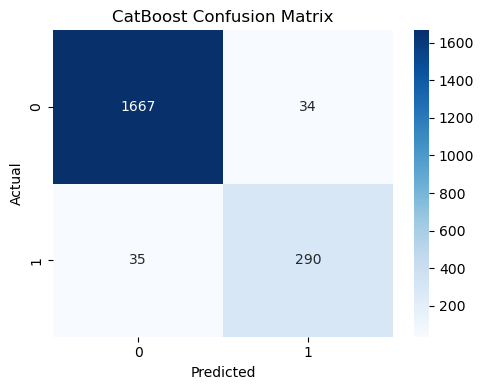


===== LightGBM =====
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      1701
           1       0.87      0.91      0.89       325

    accuracy                           0.96      2026
   macro avg       0.93      0.94      0.93      2026
weighted avg       0.96      0.96      0.96      2026

Accuracy: 0.9640
Recall: 0.9108


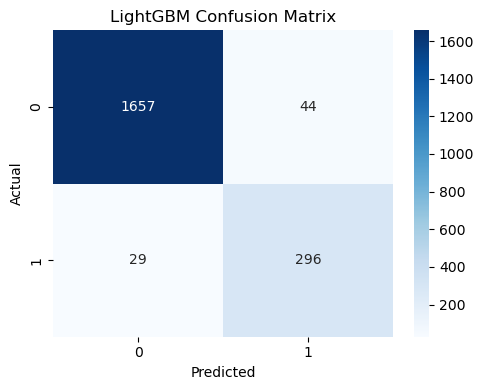

In [35]:
metrics_model(catboost_smote,'CatBoost',smote=True,X=X_train,y=y_train)
metrics_model(lgbm_smote,'LightGBM',smote=True,X=X_train,y=y_train)

In [36]:
import joblib
joblib.dump(catboost_smote, 'catboost_smote.pkl')
joblib.dump(catboost_smote, 'lightGBM_smote.pkl')

['lightGBM_smote.pkl']

###  Final Thoughts

-  **All models performed very well** with both high accuracy and recall, thanks to SMOTE improving minority class representation.
-  **CatBoost** for overall best performance balance.
-  **LightGBM** gives very similar performance with very similar recall score